## **Proyecto 1:**  Clasificación de datos aplicados.


## **Diabetes.**

### **Librerias y lectura del dataset.**

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

df1 = pd.read_csv('diabetes.csv')

### **Exploración y preprocesamiento de datasets.**

##### Información general.

In [ ]:
print(df1.info())

In [ ]:
print(df1.describe())

In [ ]:
print("Cantidad de valores unicos.")
print(df1.nunique())

##### Analisis de datos.

In [ ]:
df1.hist(bins=30, figsize=(12, 10))
plt.suptitle('Distribución de las Características Numéricas')
plt.show()

In [ ]:
# Ver cuántos ceros hay en las columnas que no deberían tener ceros
df1[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].apply(lambda x: (x == 0).sum())

In [ ]:
# Boxplot para identificar posibles valores atípicos
plt.figure(figsize=(12, 8))
sns.boxplot(data=df1, orient='h')
plt.title('Boxplot de las Características Numéricas')
plt.show()

In [ ]:
sns.countplot(x='Outcome', data=df1)
plt.title('Distribución de la Variable Objetivo (Outcome)')
plt.show()
#Conteo para ver el numero de pacientes con y sin diabetes.

#### Valores Atípicos.

In [25]:
numeric_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


for column in numeric_columns:
    outliers, lower_bound, upper_bound = identify_outliers(df1, column)
    
    print(f"Análisis de outliers para {column}:\n")
    print(f"Rango normal: {lower_bound:.2f} - {upper_bound:.2f}")
    print(f"Número de outliers: {len(outliers)}")
    print(f"Porcentaje de outliers: {(len(outliers) / len(df1)) * 100:.2f}%")
    
    if len(outliers) > 0:
        print("Estadísticas de los outliers:")
        print(outliers[column].describe())
    
    print(f"\n")

Análisis de outliers para Pregnancies:

Rango normal: -6.50 - 13.50
Número de outliers: 4
Porcentaje de outliers: 0.52%
Estadísticas de los outliers:
count     4.000000
mean     15.000000
std       1.414214
min      14.000000
25%      14.000000
50%      14.500000
75%      15.500000
max      17.000000
Name: Pregnancies, dtype: float64


Análisis de outliers para Glucose:

Rango normal: 37.12 - 202.12
Número de outliers: 5
Porcentaje de outliers: 0.65%
Estadísticas de los outliers:
count    5.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: Glucose, dtype: float64


Análisis de outliers para BloodPressure:

Rango normal: 35.00 - 107.00
Número de outliers: 45
Porcentaje de outliers: 5.86%
Estadísticas de los outliers:
count     45.000000
mean      19.244444
std       40.792800
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      122.000000
Name: BloodPressure, dtype: float64


Análisis de outliers para S

#### Tratamiento de los datos.

*(Este tratamiento no es necesario para el modelo final ya que se termino utilizando SMOTE.)*

In [77]:
#Tratamiento de balanceo de clases.

class_0 = df1[df1['Outcome'] == 0]
class_1 = df1[df1['Outcome'] == 1]

# Realizar el sobremuestreo (upsampling) de la clase minoritaria
class_1_upsampled = resample(class_1,
                             replace=True,  # con reemplazo para sobremuestrear
                             n_samples=len(class_0),  # igualar el tamaño de la clase mayoritaria
                             random_state=42)

df_balanced = pd.concat([class_0, class_1_upsampled])

#sns.countplot(x='Outcome', data=df_balanced)
#plt.title('Distribución Balanceada de la Variable Objetivo (Outcome)')
#plt.show()

*(El siguiente tratamientos **si** son necesarios)*

In [6]:
def tratar_valores_no_validos_y_outliers(df, column, lower_limit, upper_limit, replace_with='median'):
    # Primero, tratamos los valores fuera de los límites biológicamente plausibles
    valid_values = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)][column]
    if replace_with == 'median':
        replacement_value = valid_values.median()
    elif replace_with == 'mean':
        replacement_value = valid_values.mean()
    
    df.loc[df[column] < lower_limit, column] = replacement_value
    df.loc[df[column] > upper_limit, column] = replacement_value
    
    # Luego, tratamos los outliers dentro de los límites biológicos de manera más conservadora
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(lower_limit, Q1 - 1.5 * IQR)
    upper_bound = min(upper_limit, Q3 + 1.5 * IQR)
    
    df[column] = df[column].clip(lower_bound, upper_bound)
    
    return df

In [8]:
limits = {
    'Pregnancies': (0, 10),
    'Glucose': (70, 300),
    'BloodPressure': (40, 200),
    'SkinThickness': (10, 100),
    'Insulin': (10, 1000),
    'BMI': (15, 60),
    'DiabetesPedigreeFunction': (0.05, 2.5),
    'Age': (21, 90)
}

# Aplicar tratamiento para cada columna
for column, (lower, upper) in limits.items():
    df = tratar_valores_no_validos_y_outliers(df1, column, lower, upper)

#### Distribución con datos balanceados y desbalanceados.

In [ ]:
for column in df_balanced.columns[:-1]:  
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Outcome', y=column, data=df1)
    plt.title(f'Distribución de {column} por Outcome')
    plt.show()
    
#Para comparar la distribución de características entre pacientes con y sin diabetes.

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = df1.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()
#Para ver como se relaciona cada caracteristica con el outcome.

In [ ]:
plt.figure(figsize=(12, 10))
correlation_matrix = df_balanced.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()
#Para ver como se relaciona cada caracteristica con el outcome balanceado.

### **Entrenamiento de modelos.**

#### Selección y balanceo de caracteristicas.

In [16]:
def dataSelec(dataSet, columns):
    # Codificar las columnas categóricas
    categoricalCols = dataSet.select_dtypes(include=['object']).columns.tolist()
    labelEncoder = LabelEncoder()
    
    for col in categoricalCols:
        dataSet[col] = labelEncoder.fit_transform(dataSet[col])
        
    X = dataSet.drop('Outcome', axis=1) 
    y = dataSet['Outcome']  
    
    # Seleccionar las k mejores características
    selector = SelectKBest(chi2, k=columns)
    XNew = selector.fit_transform(X, y)
    selectedFeatures = selector.get_feature_names_out()
    
    # Escalar las características seleccionadas
    scaler = StandardScaler()
    XScaled = scaler.fit_transform(XNew)

    # Balanceo de clases con SMOTE
    smote = SMOTE()
    XBalanced, yBalanced = smote.fit_resample(XScaled, y)
    
    return XBalanced, yBalanced, XScaled, y, selectedFeatures

#### K-Nearest Neighbors (KNN)

In [17]:
def knn(columns, dataSet, neighbors, balanced):
    # Obtener las características balanceadas y sin balancear
    XBalanced, yBalanced, X, y, selectedFeatures = dataSelec(dataSet, columns)

    # Dividir los datos en entrenamiento, validación y prueba
    if balanced:
        X_train, X_temp, y_train, y_temp = train_test_split(XBalanced, yBalanced, test_size=0.30, random_state=42)
    else:
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
        
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

    # Crear el modelo KNN
    knn = KNeighborsClassifier(n_neighbors=neighbors)

    # Entrenar el modelo
    knn.fit(X_train, y_train)
    
    print("Selected Features:", selectedFeatures)

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = knn.predict(X_val)
    print("Validación:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Precision:", precision_score(y_val, y_val_pred))
    print("Recall:", recall_score(y_val, y_val_pred))

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = knn.predict(X_test)
    print("\nPrueba:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred))
    print("Recall:", recall_score(y_test, y_test_pred))

    # Mostrar la matriz de confusión
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d')
    plt.title('Matriz de Confusión KNN')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.show()

#### Regresión logistica.

In [22]:
def logisticRegression(dataSet, columns, balanced):
    # Obtener las características balanceadas y sin balancear
    XBalanced, yBalanced, X, y, selectedFeatures = dataSelec(dataSet, columns)

    # Dividir los datos en entrenamiento, validación y prueba
    if balanced:
        X_train, X_temp, y_train, y_temp = train_test_split(XBalanced, yBalanced, test_size=0.30, random_state=42)
    else:
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
        
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

    # Crear el modelo de regresión logística
    logistic_regression = LogisticRegression()

    # Entrenar el modelo
    logistic_regression.fit(X_train, y_train)
    
    print("Selected Features:", selectedFeatures)

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = logistic_regression.predict(X_val)
    print("Validación:")
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Precision:", precision_score(y_val, y_val_pred))
    print("Recall:", recall_score(y_val, y_val_pred))

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = logistic_regression.predict(X_test)
    print("\nPrueba:")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred))
    print("Recall:", recall_score(y_test, y_test_pred))

    # Mostrar la matriz de confusión
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d')
    plt.title('Matriz de Confusión Regresión Logística')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.show()

Selected Features: ['Glucose' 'Insulin' 'BMI' 'Age']
Validación:
Accuracy: 0.8066666666666666
Precision: 0.7362637362637363
Recall: 0.9305555555555556

Prueba:
Accuracy: 0.76
Precision: 0.7362637362637363
Recall: 0.8481012658227848


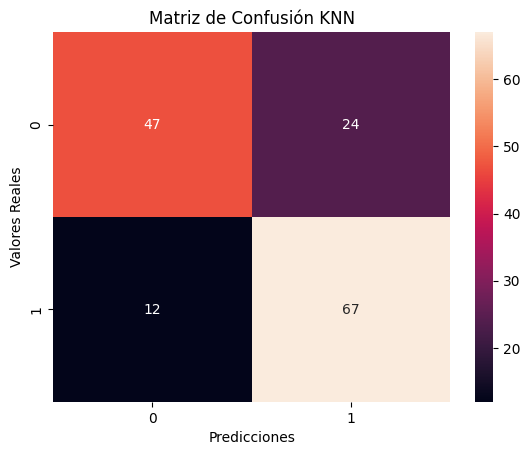

In [19]:
# Ejecutar KNN con balanceo
knn(4, df1, 5, True)

Selected Features: ['Glucose' 'Insulin' 'BMI' 'Age']
Validación:
Accuracy: 0.72
Precision: 0.7142857142857143
Recall: 0.6944444444444444

Prueba:
Accuracy: 0.72
Precision: 0.7534246575342466
Recall: 0.6962025316455697


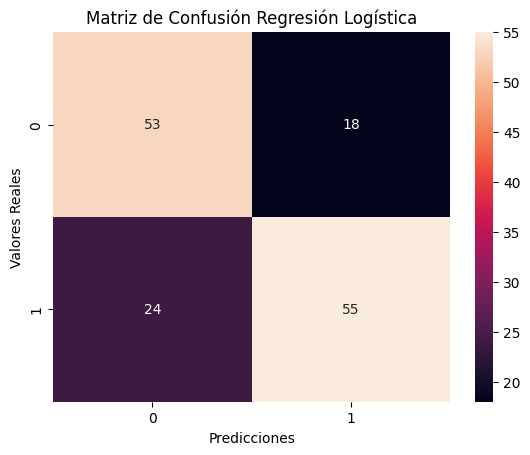

In [23]:
# Ejecutar Regresión Logística con balanceo
logisticRegression(df1, 4, True)